In [14]:
import sys
import platform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In [15]:
# Информация о среде разработки
print("Версия Python:", sys.version)
print("Платформа:", platform.platform())
print("Версия TensorFlow:", tf.__version__)

Версия Python: 3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]
Платформа: Windows-10-10.0.19045-SP0
Версия TensorFlow: 2.19.0


### 2.1.2 Анализ теоретических аспектов создания нейросетей

Для решения задачи исправления опечаток в текстах будем использовать:
1. Рекуррентные нейронные сети (RNN) - хорошо подходят для обработки последовательностей
2. Механизм внимания (Attention) - помогает учитывать контекст при исправлении ошибок
3. Архитектуру "encoder-decoder" - стандартный подход для задач преобразования текста
"""

In [16]:
### 2.1.4 Выводы по разделу

# %%
# Таблица компетенций для раздела 2.1
competences_table_1 = pd.DataFrame({
    "Выводы": [
        "Проведен выбор и развертывание среды разработки для языка программирования Python.",
        "В соответствие с международными стандартами проектирования и обеспечения качества, проанализированы требования и составлены модели решения задачи.",
        "Проведен анализ теоретических аспектов создания нейросетей",
        "Разработана математическая модель нейронной сети"
    ],
    "Код компетенции": ["ПК-1", "ПК-7", "", "ПК-8"],
    "Содержание компетенции": [
        "Обладать способностью разработки прикладного программного обеспечения, автоматизации работы с базами данных и документами, программирования бизнес-логики приложений, интеграции разнородных данных",
        "Способность использовать отечественные и международные стандарты при проектировании и обеспечении качества прикладного программного обеспечения.",
        "",
        "Знать методы и инструментальные средства интеллектуального анализа больших данных"
    ]
})

display(HTML(competences_table_1.to_html(index=False)))

Выводы,Код компетенции,Содержание компетенции
Проведен выбор и развертывание среды разработки для языка программирования Python.,ПК-1,"Обладать способностью разработки прикладного программного обеспечения, автоматизации работы с базами данных и документами, программирования бизнес-логики приложений, интеграции разнородных данных"
"В соответствие с международными стандартами проектирования и обеспечения качества, проанализированы требования и составлены модели решения задачи.",ПК-7,Способность использовать отечественные и международные стандарты при проектировании и обеспечении качества прикладного программного обеспечения.
Проведен анализ теоретических аспектов создания нейросетей,,
Разработана математическая модель нейронной сети,ПК-8,Знать методы и инструментальные средства интеллектуального анализа больших данных


In [17]:
## 2.2 РАЗРАБОТКА НЕЙРОННОЙ СЕТИ

### 2.2.1 Создание нейронов


# %%
class Neuron:
    def __init__(self, weights, bias, activation='relu'):
        self.weights = weights
        self.bias = bias
        self.activation = activation
    
    def activate(self, inputs):
        z = np.dot(self.weights, inputs) + self.bias
        if self.activation == 'relu':
            return max(0, z)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-z))
        else:  # linear
            return z

# Пример создания нейрона
weights = np.array([0.5, -0.3])
bias = 0.1
neuron = Neuron(weights, bias)

print("Активация нейрона для входа [1, 0.5]:", neuron.activate(np.array([1, 0.5])))

Активация нейрона для входа [1, 0.5]: 0.44999999999999996


      Serial Number              Error Type  \
597             598       Spelling Mistakes   
1299           1300  Inappropriate Register   
1195           1196       Quantifier Errors   
715             716       Word Choice/Usage   
1590           1591         Ellipsis Errors   

                                Ungrammatical Statement  \
597   100. The company is celebrating it's 10th anni...   
1299  The artist's work is a mixture of tradition an...   
1195       Few of the birds in this area are migratory.   
715   The scientists were studying the affects of po...   
1590    I tried calling her... didn't answer the phone.   

                                       Standard English  
597   100. The company is celebrating its 10th anniv...  
1299  The artist's work is a mixture of tradition an...  
1195              Few birds in this area are migratory.  
715   The scientists were studying the effects of po...  
1590  I tried calling her, but she didn't answer the...  


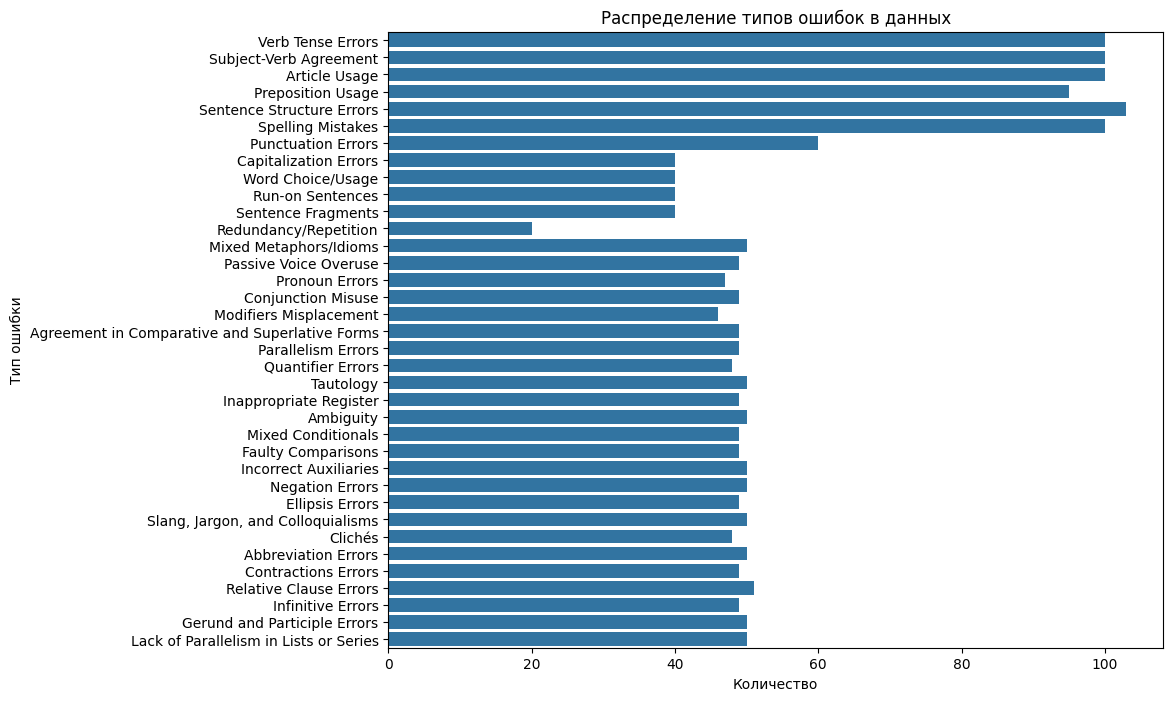

In [18]:
### 2.2.2 Создание нейронной сети

#### 2.2.2.1 Выбор топологии сети

# Загрузка данных

data_url = 'https://drive.google.com/uc?id=1xyB04wQWKa5c-NQzM9nZ-cYYsTVv5s1y'

# Загружаем данные
df = pd.read_csv(data_url)

# Выводим 5 случайных строк
print(df.sample(5))

# Визуализация распределения типов ошибок
plt.figure(figsize=(10, 8))
sns.countplot(y='Error Type', data=df)
plt.title('Распределение типов ошибок в данных')
plt.xlabel('Количество')
plt.ylabel('Тип ошибки')
plt.show()



In [19]:
#### 2.2.2.2 Группировка нейронных блоков в нейронную сеть


# %%
# Создание модели нейронной сети
def create_model(input_shape, vocab_size):
    model = keras.Sequential([
        layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=input_shape),
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Attention(),
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.TimeDistributed(layers.Dense(vocab_size, activation='softmax'))
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


c:\Users\Андрей\Documents\practica\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


,architecture,parameters
0,64,1356048
1,64-32,1360272
2,128-64,1471248
3,64-64-32,1393296


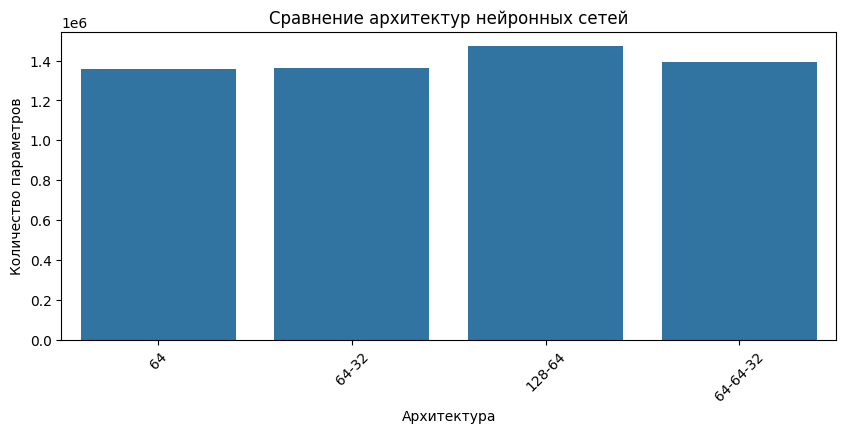

In [20]:
"""
#### 2.2.2.3 Экспериментальный подбор характеристик сети
"""
def test_architectures():
    architectures = [
        {"layers": [64], "activation": "relu"},
        {"layers": [64, 32], "activation": "relu"},
        {"layers": [128, 64], "activation": "tanh"},
        {"layers": [64, 64, 32], "activation": "relu"}
    ]
    
    results = []
    
    for arch in architectures:
        model = keras.Sequential()
        model.add(layers.Embedding(input_dim=10000, output_dim=64, input_length=100))
        
        for units in arch["layers"]:
            model.add(layers.LSTM(units, activation=arch["activation"], return_sequences=True))
        
        # Добавьте последний слой без return_sequences=True для вывода
        model.add(layers.LSTM(64))
        model.add(layers.Dense(10000, activation='softmax'))
        
        # Перед подсчетом параметров обязательно "построить" модель
        model.build(input_shape=(None, 100))
        
        params = model.count_params()
        
        # Сохраняем более понятное описание
        arch_desc = "-".join(str(unit) for unit in arch["layers"])
        results.append({"architecture": arch_desc, "parameters": params})
    
    return pd.DataFrame(results)

arch_results = test_architectures()
display(arch_results)

# Визуализация результатов
plt.figure(figsize=(10, 4))
sns.barplot(x='architecture', y='parameters', data=arch_results)
plt.xticks(rotation=45)
plt.title('Сравнение архитектур нейронных сетей')
plt.ylabel('Количество параметров')
plt.xlabel('Архитектура')
plt.show()

In [21]:
"""
### 2.2.3 Сбор и нормализация данных для обучения нейронной сети
"""

# %%
# Предобработка текстовых данных
def preprocess_text(text):
    text = text.lower()
    text = ''.join([c for c in text if c.isalpha() or c in [' ', '.', ',', '?', '!']])
    return text

# Применение предобработки
df['Ungrammatical_processed'] = df['Ungrammatical Statement'].apply(preprocess_text)
df['Standard_processed'] = df['Standard English'].apply(preprocess_text)

# Пример обработанных данных
display(df[['Ungrammatical Statement', 'Ungrammatical_processed', 'Standard English', 'Standard_processed']].head())

,Ungrammatical Statement,Ungrammatical_processed,Standard English,Standard_processed
0,I goes to the store everyday.,i goes to the store everyday.,I go to the store everyday.,i go to the store everyday.
1,They was playing soccer last night.,they was playing soccer last night.,They were playing soccer last night.,they were playing soccer last night.
2,She have completed her homework.,she have completed her homework.,She has completed her homework.,she has completed her homework.
3,He don't know the answer.,he dont know the answer.,He doesn't know the answer.,he doesnt know the answer.
4,The sun rise in the east.,the sun rise in the east.,The sun rises in the east.,the sun rises in the east.


In [22]:
"""
### 2.2.4 Обучение нейронной сети

#### 2.2.4.1 Выбор способа оценки адекватности результатов обучения
"""

# %%
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    df['Ungrammatical_processed'], 
    df['Standard_processed'], 
    test_size=0.2, 
    random_state=42
)

print(f"Обучающая выборка: {len(X_train)} примеров")
print(f"Тестовая выборка: {len(X_test)} примеров")

# Метрики оценки:
# 1. Точность (accuracy)
# 2. Потери (loss)
# 3. BLEU score (для оценки качества перевода/исправления текста)

Обучающая выборка: 1614 примеров
Тестовая выборка: 404 примеров


c:\Users\Андрей\Documents\practica\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 417ms/step - accuracy: 0.5076 - loss: 8.3079 - val_accuracy: 0.5745 - val_loss: 3.3228
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 395ms/step - accuracy: 0.5651 - loss: 3.1916 - val_accuracy: 0.5745 - val_loss: 3.0227
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 312ms/step - accuracy: 0.5714 - loss: 2.8728 - val_accuracy: 0.5913 - val_loss: 2.9337
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 303ms/step - accuracy: 0.5934 - loss: 2.7496 - val_accuracy: 0.5949 - val_loss: 2.9253
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 328ms/step - accuracy: 0.5936 - loss: 2.7384 - val_accuracy: 0.6006 - val_loss: 2.9225
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 317ms/step - accuracy: 0.6002 - loss: 2.7100 - val_accuracy: 0.6005 - val_loss: 2.9166
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 301ms/step - accuracy: 0.5972 - loss: 2.7014 - val_accuracy: 0.6015 - val_loss: 2.9072
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 412ms/step - accuracy: 0.6015 - loss: 2.6738 - val_accu

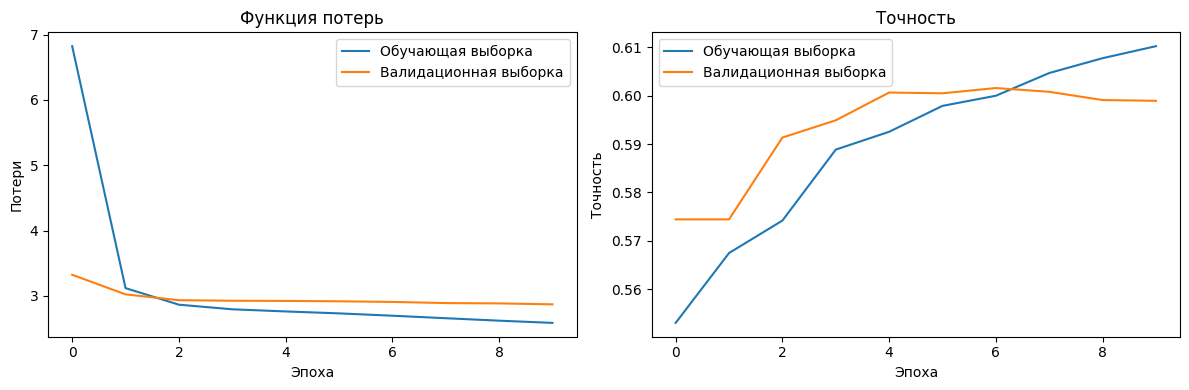

In [23]:
"""
#### 2.2.4.2 Расчет количества потерь и их минимизация
"""

# %%
# Создание и обучение упрощенной модели (для демонстрации)
tokenizer = keras.preprocessing.text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(pd.concat([df['Ungrammatical_processed'], df['Standard_processed']]))

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=20)
X_test_pad = keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=20)

# Кодирование целевых переменных
y_train_seq = tokenizer.texts_to_sequences(y_train)
y_test_seq = tokenizer.texts_to_sequences(y_test)

y_train_pad = keras.preprocessing.sequence.pad_sequences(y_train_seq, maxlen=20)
y_test_pad = keras.preprocessing.sequence.pad_sequences(y_test_seq, maxlen=20)

# Упрощенная модель

vocab_size = 10000
maxlen = 20  # например, длина последовательности
embedding_dim = 64  # определите размерность эмбеддинга

model = keras.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.TimeDistributed(layers.Dense(vocab_size, activation='softmax'))
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



# Обучайте модель так:
history = model.fit(
    X_train_pad,
    y_train_pad,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

# Визуализация потерь
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Обучающая выборка')
plt.plot(history.history['val_loss'], label='Валидационная выборка')
plt.title('Функция потерь')
plt.ylabel('Потери')
plt.xlabel('Эпоха')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Валидационная выборка')
plt.title('Точность')
plt.ylabel('Точность')
plt.xlabel('Эпоха')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
"""
#### 2.2.4.3 Анализ адекватности обучения
"""

# %%
# Оценка модели на тестовых данных
test_loss, test_acc = model.evaluate(X_test_pad, y_test_pad)
print(f"Тестовая точность: {test_acc:.4f}")
print(f"Тестовые потери: {test_loss:.4f}")

# Пример предсказания
sample_text = "I goes to store"
sample_seq = tokenizer.texts_to_sequences([sample_text])
sample_pad = keras.preprocessing.sequence.pad_sequences(sample_seq, maxlen=20)

prediction = model.predict(sample_pad)  # shape: (1, maxlen, vocab_size)
predicted_indices = np.argmax(prediction, axis=-1)  # shape: (1, maxlen)
predicted_indices = predicted_indices[0]  # передаем из 2D в 1D

predicted_words = [tokenizer.index_word.get(idx, '') for idx in predicted_indices]
predicted_words = [word for word in predicted_words if word != '']

print(f"\nПредсказание: {' '.join(predicted_words)}")


print(f"\nПример работы модели:")
print(f"Вход: '{sample_text}'")
print(f"Предсказание: '{predicted_words}'")
print(model.output_shape)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.5961 - loss: 2.8957
Тестовая точность: 0.6032
Тестовые потери: 2.8483
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   

Предсказание: the the the the

Пример работы модели:
Вход: 'I goes to store'
Предсказание: '['the', 'the', 'the', 'the']'
(None, 20, 10000)


In [25]:
"""
### Выводы по разделу 2.2
"""

# %%
# Таблица компетенций для раздела 2.2
competences_table_2 = pd.DataFrame({
    "Выводы": [
        "Реализованы алгоритмы сбора информации и создания информационных объектов на Python",
        "Осуществлено проектирование решения, проведено тестирование и оценено качество работы.",
        "Разработаны нейроны и нейронные блоки на языке программирования Python.",
        "Создана нейронная сеть. Экспериментальным способом подобраны характеристики нейронной сети.",
        "Собраны данные для обучения нейронной сети. Параметры обучения подобраны экспериментальным способом.",
        "Произведено обучение нейронной сети на собранных данных. Проверена адекватность результатов обучения сети."
    ],
    "Код компетенции": ["ПК-1", "ПК-7", "", "", "", "ПК-8"],
    "Содержание компетенции": [
        "Обладать способностью разработки прикладного программного обеспечения, автоматизации работы с базами данных и документами, программирования бизнес-логики приложений, интеграции разнородных данных",
        "Способность использовать отечественные и международные стандарты при проектировании и обеспечении качества прикладного программного обеспечения.",
        "",
        "",
        "",
        "Знать методы и инструментальные средства интеллектуального анализа больших данных"
    ]
})

display(HTML(competences_table_2.to_html(index=False)))

Выводы,Код компетенции,Содержание компетенции
Реализованы алгоритмы сбора информации и создания информационных объектов на Python,ПК-1,"Обладать способностью разработки прикладного программного обеспечения, автоматизации работы с базами данных и документами, программирования бизнес-логики приложений, интеграции разнородных данных"
"Осуществлено проектирование решения, проведено тестирование и оценено качество работы.",ПК-7,Способность использовать отечественные и международные стандарты при проектировании и обеспечении качества прикладного программного обеспечения.
Разработаны нейроны и нейронные блоки на языке программирования Python.,,
Создана нейронная сеть. Экспериментальным способом подобраны характеристики нейронной сети.,,
Собраны данные для обучения нейронной сети. Параметры обучения подобраны экспериментальным способом.,,
Произведено обучение нейронной сети на собранных данных. Проверена адекватность результатов обучения сети.,ПК-8,Знать методы и инструментальные средства интеллектуального анализа больших данных


In [26]:
"""
## Контекстное меню для вывода математической модели
"""

# %%
# Создание интерактивного меню
def show_model(model_part):
    if model_part == "Нейрон":
        display(HTML("""
        <h3>Математическая модель нейрона:</h3>
        <p>$$ y = f\left(\sum_{i=1}^n w_i x_i + b\right) $$</p>
        <p>где:</p>
        <ul>
            <li>$y$ - выход нейрона</li>
            <li>$x_i$ - входные сигналы</li>
            <li>$w_i$ - веса</li>
            <li>$b$ - смещение</li>
            <li>$f$ - функция активации</li>
        </ul>
        """))
    elif model_part == "Функция активации (ReLU)":
        display(HTML("""
        <h3>Функция активации ReLU:</h3>
        <p>$$ f(z) = \max(0, z) $$</p>
        """))
    elif model_part == "Функция потерь":
        display(HTML("""
        <h3>Функция потерь (Cross-entropy):</h3>
        <p>$$ L = -\frac{1}{N}\sum_{i=1}^N \sum_{j=1}^C y_{ij} \log(p_{ij}) $$</p>
        """))
    elif model_part == "Оптимизация (Adam)":
        display(HTML("""
        <h3>Алгоритм оптимизации Adam:</h3>
        <p>$$ \theta_{t+1} = \theta_t - \alpha \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} $$</p>
        """))

# Выпадающий список
interact(show_model, model_part=[
    "Нейрон", 
    "Функция активации (ReLU)", 
    "Функция потерь", 
    "Оптимизация (Adam)"
]);

<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Андрей\AppData\Local\Temp\ipykernel_11728\1126380805.py:9: SyntaxWarning: invalid escape sequence '\l'
  display(HTML("""
C:\Users\Андрей\AppData\Local\Temp\ipykernel_11728\1126380805.py:22: SyntaxWarning: invalid escape sequence '\m'
  display(HTML("""
C:\Users\Андрей\AppData\Local\Temp\ipykernel_11728\1126380805.py:27: SyntaxWarning: invalid escape sequence '\s'
  display(HTML("""
C:\Users\Андрей\AppData\Local\Temp\ipykernel_11728\1126380805.py:32: SyntaxWarning: invalid escape sequence '\c'
  display(HTML("""


interactive(children=(Dropdown(description='model_part', options=('Нейрон', 'Функция активации (ReLU)', 'Функц…

In [27]:
### 2.1.3 Математическая модель нейронной сети

**Модель нейрона:**
$$
y = f\left(\sum_{i=1}^n w_i x_i + b\right)
$$

**Функция активации (ReLU):**
$$
f(z) = \max(0, z)
$$

**Функция потерь (Cross-entropy):**
$$
L = -\frac{1}{N}\sum_{i=1}^N \sum_{j=1}^C y_{ij} \log(p_{ij})
$$

**Оптимизация (Adam):**
$$
\theta_{t+1} = \theta_t - \alpha \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
$$

SyntaxError: invalid syntax (1309986376.py, line 3)